# Machinegnostics GDF Tutorial: From Concepts to Comparisons

Welcome! This notebook is a step-by-step learner guide to Gnostic Distribution Functions (GDF) in the Machinegnostics library using Anscombe’s Quartet.

Goals
- Understand GDF classes (EGDF, ELDF, QGDF, QLDF) via the E vs Q and L vs G axes.
- Compare ELDF against empirical CDF and KDE/Histogram PDF.
- Compute summary statistics and correlations using both NumPy and Machinegnostics.
- Run side-by-side linear regression (sklearn vs Machinegnostics), then compare metrics and visuals.

Roadmap
1) Setup & Data Loading
2) Learn GDF Concepts (overview + ELDF details)
3) ELDF vs CDF/PDF Visual Comparison
4) Stats & Correlation Table (NumPy vs Machinegnostics)
5) Regression Prep (build DataFrame)
6) Regression Comparison (sklearn vs MG)
7) Wrap-up & Next Steps


In [ ]:
# !pip install machinegnostics

In [30]:
from machinegnostics.magcal import ELDF, EGDF
from machinegnostics.data import make_anscombe_check_data
from machinegnostics.metrics import correlation, mean, median, robr2, variance
import numpy as np

In [68]:
help(make_anscombe_check_data)

Help on function make_anscombe_check_data in module machinegnostics.data.anscombe_data:

make_anscombe_check_data(dataset_id=1)
    Retrieves one of the four datasets from Anscombe's Quartet.
    
    Anscombe's quartet comprises four datasets that have nearly identical simple 
    descriptive statistics (mean, variance, correlation, regression line), yet 
    have very different distributions and appear very different when graphed.
    Ideally suited for demonstrating robust regression/gnostic models.
    
    Parameters
    ----------
    dataset_id : int, optional
        The identifier of the dataset to retrieve (1, 2, 3, or 4).
        1. Simple linear relationship with some noise.
        2. Non-linear relationship (polynomial).
        3. Linear relationship with a single outlier.
        4. Vertical line with one influential outlier.
        Default is 1.
    
    Returns
    -------
    X : numpy.ndarray
        The input feature array of shape (11,).
    y : numpy.ndarray
   

In [69]:
x_1, y_1 = make_anscombe_check_data(dataset_id=1)
x_1 = np.array(x_1).flatten()
y_1 = np.array(y_1).flatten()

x_2, y_2 = make_anscombe_check_data(dataset_id=2)
x_2 = np.array(x_2).flatten()
y_2 = np.array(y_2).flatten()

x_3, y_3 = make_anscombe_check_data(dataset_id=3)
x_3 = np.array(x_3).flatten()
y_3 = np.array(y_3).flatten()

x_4, y_4 = make_anscombe_check_data(dataset_id=4)
x_4 = np.array(x_4).flatten()
y_4 = np.array(y_4).flatten()

## Step 1 — Setup & Data Loading

We load Anscombe’s Quartet (x, y) for datasets 1–4. Each dataset shares similar summary stats but different scatter patterns. Shapes are flattened to 1D for downstream analysis.


## Machine Gnostics vs Statistical Distributions



## ELDF Documentation (Learner Guide)

This section summarizes ELDF based on the official Machinegnostics docs and adapts it for practical use in this notebook.

- What it is: ELDF (Estimating Local Distribution Function) builds an assumption-free, robust local distribution from your data. It avoids fixed parametric families and is resilient to outliers, inner noise, and mixed forms.
- When to use: Small samples, non-Gaussian data, contaminated datasets, heteroscedastic spread, or when classical histogram/KDE becomes unstable.
- Why it helps: ELDF produces smooth, monotone distribution curves; estimates local scale and bounds automatically; and supports variance-sensitive fitting via `varS`.

Key features
- Assumption-free: No fixed parametric distribution required.
- Robust: Handles outliers and inner noise.
- Flexible data forms: Additive (`'a'`) and multiplicative (`'m'`).
- Weighted data: Optional sample weights and WEDF support.
- Auto parameters: Scale (`S`) and bounds (`LB`, `UB`) inferred; manual override available.
- Advanced `z0` optimization: Learns location/peak for local density.
- Memory-efficient: Options to manage large arrays (`catch`, `flush`, `max_data_size`).
- Visualization: Built-in ELDF/PDF plotting; diagnostics available via `results()`.

Core parameters (common)
- `LB`, `UB`: Practical lower/upper bounds (optional). `DLB`, `DUB` are absolute bounds.
- `S`: Scale (float or `'auto'`); governs smoothing.
- `varS`: Variable scale (bool). If `True`, scale adapts to local variance; use `minimum_varS` to set floor.
- `data_form`: `'a'` or `'m'` depending on additive vs multiplicative behavior.
- `n_points`: Number of curve points to generate.
- `weights`: Prior weights for each sample (optional); `wedf=True` uses a weighted EDF.
- `opt_method`, `tolerance`, `verbose`: Optimization settings (e.g., `'Powell'`).

Methods
- `fit(data, plot=False)`: Fits ELDF to a 1D array. Stores fitted parameters and curves in `params` and accessible attributes.
- `plot(plot_smooth=True, plot='both', bounds=True, extra_df=True)`: Visualizes ELDF and PDF with optional bounds and extras.
- `results()`: Returns a `dict` containing fitted scale, bounds, diagnostics, and more.

Typical workflow
1) Initialize: `eldf = ELDF(varS=False)` (or `True` for heteroscedastic cases).
2) Fit: `eldf.fit(data)`; optionally `plot=True` during development.
3) Inspect: `res = eldf.results()` to view `S_opt`, `LB`, `UB`, diagnostics.
4) Visualize: Use `eldf.plot()` or custom plots via `di_points_n`, `eldf_points`, and `pdf_points`.

Interpretation tips
- ELDF vs Empirical CDF: ELDF smooths and regularizes the staircase EDF; better for small samples.
- ELDF vs KDE/Histogram: ELDF avoids bin/bandwidth sensitivity; KDE can over/under-smooth.
- `varS=True`: Enables variance-sensitive shaping to reveal heteroscedastic spread.
- Bounds: Check `LB/UB` to understand practical support; adjust if domain constraints are known.

Best practices
- Start with `S='auto'` and `varS=False`, then enable `varS=True` if spread varies.
- Use weights if certain samples are more reliable/representative.
- For large arrays, set `catch=False` and/or `flush=True` to manage memory.
- Compare visually against empirical CDF and KDE PDF for intuition (as done below).

Reference: Adapted from the official ELDF documentation at machinegnostics.info. See additional links for EGDF and broader GDF concepts.


## Step 2 — Learn GDF Concepts

Read this overview to understand the two selection axes (Estimating vs Quantifying, Local vs Global) and which class to use when. Then continue to ELDF-specific guidance.


## GDF (Gnostic Distribution Functions) — Learner Overview

GDFs are robust, assumption-free probability and density estimators. Instead of fixing a parametric curve (e.g., Gaussian), they let the data determine the distribution structure using gnostic algebra and error geometry.

Selection axes
- Estimating (E) vs Quantifying (Q):
  - E-Type (Estimating): Robust to outliers. Focuses on central structure; suppresses extremes to reveal the “normal” behavior.
  - Q-Type (Quantifying): Robust to inliers. Emphasizes peripheral structure; suppresses central mass to highlight anomalies.
- Local (L) vs Global (G):
  - L-Type (Local): Highly flexible; can represent multi-modality and fine inner structure.
  - G-Type (Global): More rigid; typically unimodal; suited for overall trend and homogeneity.

Classes & best use
- EGDF (E/G): Standard global estimator. Use for homogeneity testing, valid data bounds, normal data estimation.
- ELDF (E/L): Structure seeker. Tight around clusters; dampens outliers. Use for marginal cluster and interval analysis.
- QGDF (Q/G): Anomaly modeler. Highlights global deviations when the center is considered noise.
- QLDF (Q/L): Detail seeker. Emphasizes peripheral details for complex, anomaly-focused analysis.

Key parameters
- Scale `S`: Controls resolution/curvature. Small `S` → fine details; large `S` → smoother. Typically auto-optimized in global models.
- Variable scale `varS`: If True, scale adapts locally (heteroscedasticity). Use to reveal varying spread.
- Irrelevance `h`: Encodes datum uncertainty/error; GDFs weigh these irrelevances to balance entropy and information.

Practical guidance
- Want the “true” central behavior? Prefer EGDF.
- Want subgroups/clusters inside that behavior? Prefer ELDF.
- Want to highlight anomalies globally? Prefer QGDF.
- Want peripheral-detail emphasis and complex structures? Prefer QLDF.

Pointers
- Compare ELDF with empirical CDF and KDE PDF to see smoothing vs jaggedness and bandwidth sensitivity.
- Use `results()` to inspect learned bounds (`LB/UB`), scale, and diagnostics.
- Start with `S='auto'`, `varS=False`; enable `varS=True` when spread varies across the domain.


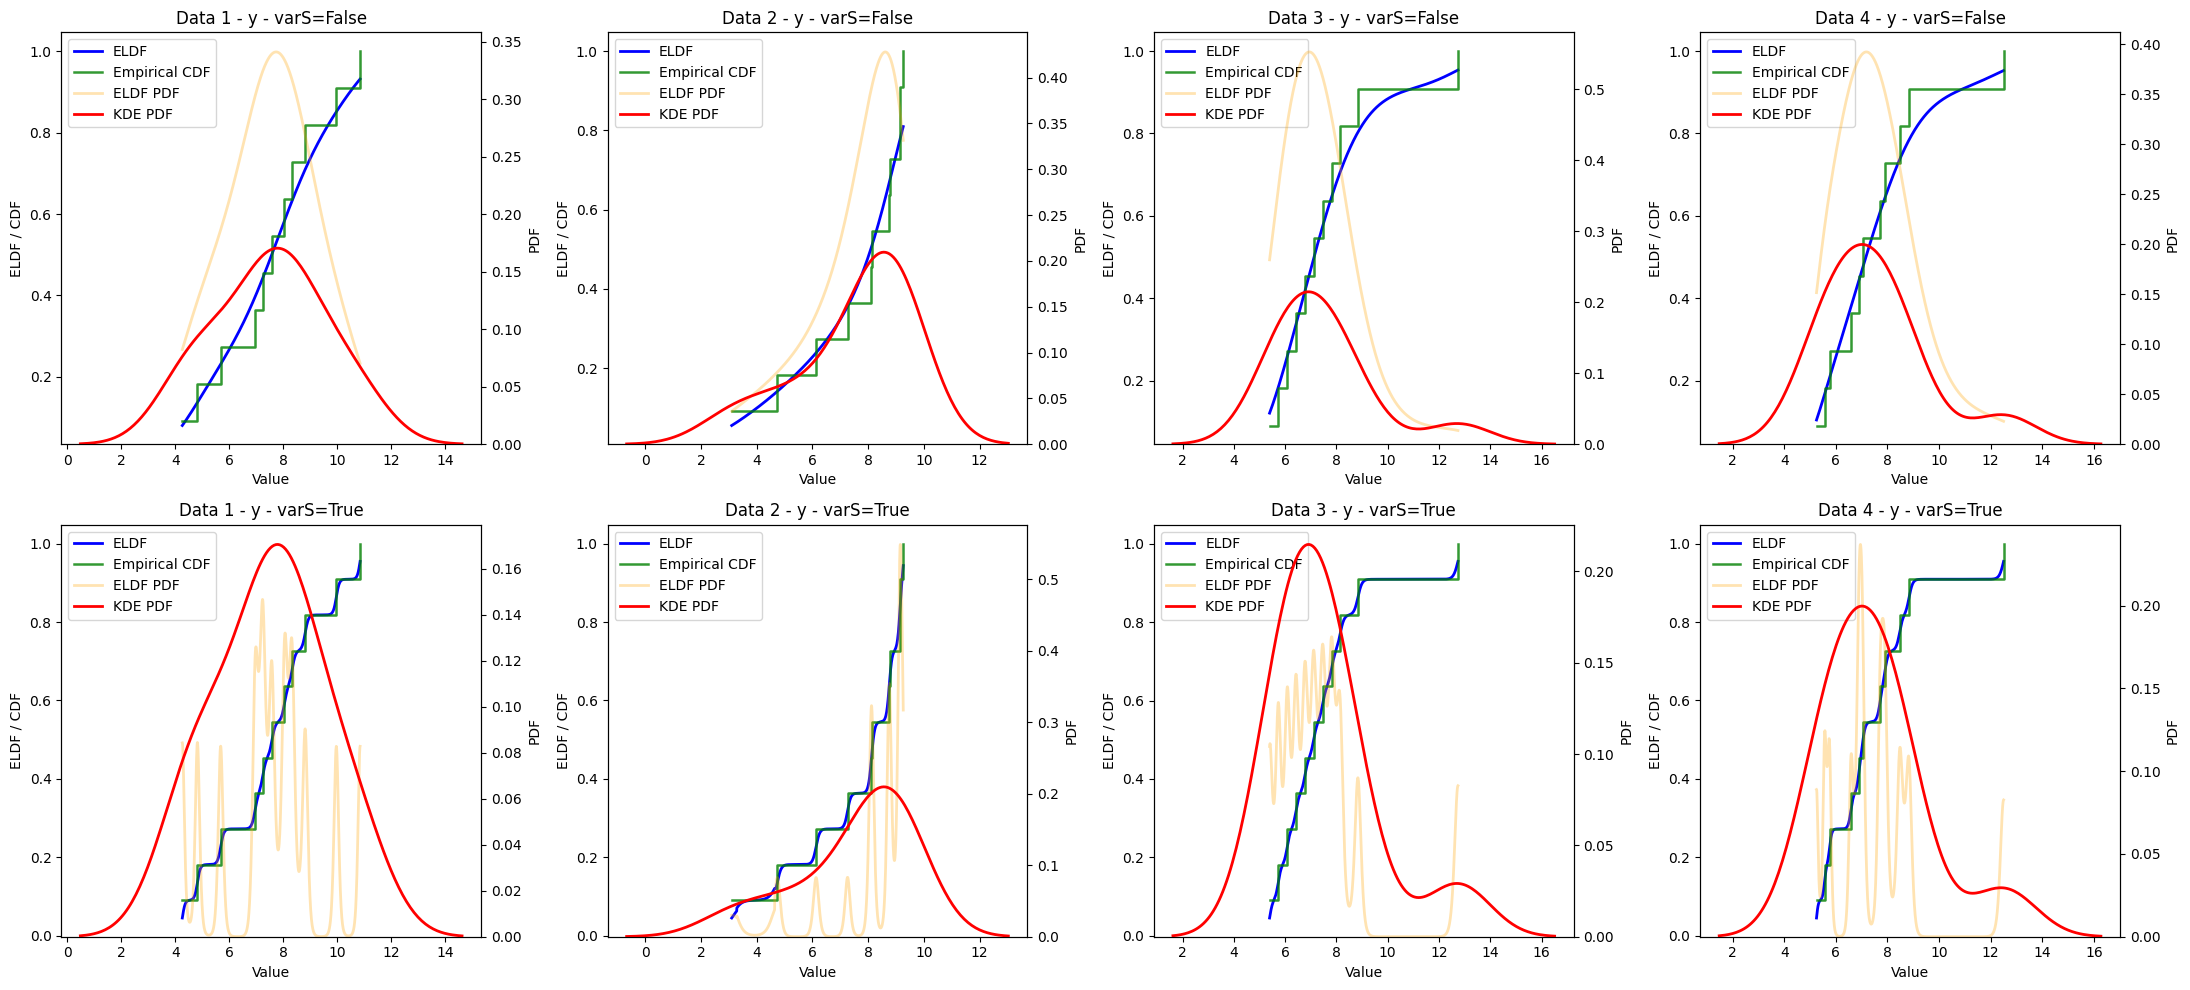

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Helper: draw ELDF + PDF on provided axes using fitted arrays safely
def draw_eldf_on_ax(ax, data, varS=False, title=None):
    model = ELDF(varS=varS)
    model.fit(np.asarray(data))
    # Prefer model evaluation points; fallback to data range
    x_points = getattr(model, 'di_points_n', None)
    if x_points is None:
        x_points = np.linspace(float(np.min(data)), float(np.max(data)), 300)
    eldf_vals = getattr(model, 'eldf_points', None)
    pdf_vals = getattr(model, 'pdf_points', None)

    # ELDF line
    if isinstance(eldf_vals, np.ndarray) and eldf_vals.shape == x_points.shape:
        ax.plot(x_points, eldf_vals, color='blue', linestyle='-', linewidth=2, alpha=0.9, label='ELDF')

    # Optional KS/WEDF points only if shapes align
    wedf_vals = getattr(model, 'wedf', None)
    if isinstance(wedf_vals, np.ndarray) and wedf_vals.shape == x_points.shape:
        ax.plot(x_points, wedf_vals, 's', color='cyan', markersize=2, alpha=0.6, label='KS Points')

    # PDF on right axis when available
    ax2 = ax.twinx()
    if isinstance(pdf_vals, np.ndarray) and pdf_vals.shape == x_points.shape:
        ax2.plot(x_points, pdf_vals, color='red', linestyle='-', linewidth=2, alpha=0.9, label='ELDF PDF')

    if title:
        ax.set_title(title)
    ax.set_xlabel('Data Points')
    ax.set_ylabel('ELDF')
    ax2.set_ylabel('PDF')
    return ax

# New helper: plot ELDF vs empirical CDF and KDE/Hist PDF

def plot_eldf_cdf_pdf(ax, data, varS=False, title=None):
    arr = np.asarray(data)
    model = ELDF(varS=varS)
    model.fit(arr)

    x_points = getattr(model, 'di_points_n', None)
    if x_points is None:
        x_points = np.linspace(float(np.min(arr)), float(np.max(arr)), 300)
    eldf_vals = getattr(model, 'eldf_points', None)
    eldf_pdf_vals = getattr(model, 'pdf_points', None)

    # ELDF (CDF-like curve)
    if isinstance(eldf_vals, np.ndarray) and eldf_vals.shape == x_points.shape:
        ax.plot(x_points, eldf_vals, color='blue', linewidth=2, label='ELDF')

    # Empirical CDF
    s = np.sort(arr)
    cdf = np.arange(1, s.size + 1) / float(s.size)
    ax.step(s, cdf, where='post', color='green', linewidth=1.8, alpha=0.8, label='Empirical CDF')

    # KDE / Histogram PDF and ELDF PDF on twin axis
    ax2 = ax.twinx()
    # ELDF PDF
    if isinstance(eldf_pdf_vals, np.ndarray) and eldf_pdf_vals.shape == x_points.shape:
        ax2.plot(x_points, eldf_pdf_vals, color='orange', alpha=0.3, linewidth=2, label='ELDF PDF')
    # KDE PDF (fallback to histogram)
    try:
        sns.kdeplot(x=arr, ax=ax2, color='red', linewidth=2, label='KDE PDF')
    except Exception:
        hist_y, hist_x = np.histogram(arr, bins='auto', density=True)
        ax2.plot(hist_x[:-1], hist_y, color='red', linewidth=2, label='Hist PDF')

    ax.set_xlabel('Value')
    ax.set_ylabel('ELDF / CDF')
    ax2.set_ylabel('PDF')
    if title:
        ax.set_title(title)
    # Legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc='best', fontsize=10)

# Demonstration: 2x4 grid comparing ELDF vs CDF/PDF for Anscombe y across datasets 1–4
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(22, 10), sharex=False)

for col, y_data in enumerate([y_1, y_2, y_3, y_4]):
    plot_eldf_cdf_pdf(axes[0, col], y_data, varS=False, title=f"Data {col+1} - y - varS=False")
    plot_eldf_cdf_pdf(axes[1, col], y_data, varS=True,  title=f"Data {col+1} - y - varS=True")

plt.tight_layout()
plt.savefig("eldf_vs_cdf_pdf_y_2x4.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot interpretation guide
# - Blue ELDF should appear smoother than the green empirical CDF staircase.
# - Orange ELDF PDF (model-derived) vs Red KDE PDF: compare shapes and stability (ELDF PDF uses learned scale; KDE is bandwidth-sensitive).
# - varS=True (bottom row) often reveals varying spread across the domain.


## Step 3 — ELDF vs Empirical CDF & KDE PDF

In this step, we visually compare ELDF (blue) to the empirical CDF (green) and KDE/Histogram PDF (red). The top row uses `varS=False` (baseline), and the bottom row uses `varS=True` (variance-sensitive). Observe smoothness, stability, and how `varS` reveals heteroscedastic spread.


In [ ]:
# machine gnostics mean of each data

# Compute MG mean (library) and statistical mean (numpy) for datasets 1–4
mg_means = []
stat_means = []
for idx, data in enumerate([x_1, x_2, x_3, x_4], start=1):
    mg_means.append(mean(data))
    stat_means.append(float(np.mean(data)))

# Print means for all datasets
for i in range(4):
    print(f"MG mean - data {i+1}: {mg_means[i]}")
    print(f"Statistical mean - data {i+1}: {stat_means[i]}")

MG mean - data 1: 9.0
Statistical mean - data 1: 9.0
MG mean - data 2: 9.0
Statistical mean - data 2: 9.0
MG mean - data 3: 9.0
Statistical mean - data 3: 9.0
MG mean - data 4: 8.0
Statistical mean - data 4: 9.0


In [ ]:
# machine gnostics median of each data

# Compute MG median (library) and statistical median (numpy) for datasets 1–4
mg_medians = []
stat_medians = []
for idx, data in enumerate([data_1, data_2, data_3, data_4], start=1):
    mg_medians.append(median(data))
    stat_medians.append(float(np.median(data)))

# Print medians for all datasets
for i in range(4):
    print(f"MG median - data {i+1}: {mg_medians[i]}")
    print(f"Statistical median - data {i+1}: {stat_medians[i]}")

MG median - data 1: 8.08
Statistical median - data 1: 8.02
MG median - data 2: 8.3538
Statistical median - data 2: 8.440000000000001
MG median - data 3: 7.640000000000001
Statistical median - data 3: 7.635
MG median - data 4: 7.890000000000001
Statistical median - data 4: 8.0


In [82]:
# MG and statistical mean/median/correlation for x and y (datasets 1–4)

# Compute and print stats for both x and y
stats_results = []
for i, (x_data, y_data) in enumerate(zip([x_1, x_2, x_3, x_4], [y_1, y_2, y_3, y_4]), start=1):
    # Means & medians (NumPy)
    mean_x_np = float(np.mean(x_data))
    median_x_np = float(np.median(x_data))
    mean_y_np = float(np.mean(y_data))
    median_y_np = float(np.median(y_data))

    # Means & medians (Machinegnostics)
    mean_x_mg = float(mean(x_data))
    median_x_mg = float(median(x_data))
    mean_y_mg = float(mean(y_data))
    median_y_mg = float(median(y_data))

    # Correlation (NumPy & Machinegnostics)
    corr_np = float(np.corrcoef(x_data, y_data)[0, 1])
    corr_mg = float(correlation(X=x_data, y=y_data))

    stats_results.append({
        "dataset": i,
        "mean_x_np": mean_x_np,
        "mean_x_mg": mean_x_mg,
        "median_x_np": median_x_np,
        "median_x_mg": median_x_mg,
        "mean_y_np": mean_y_np,
        "mean_y_mg": mean_y_mg,
        "median_y_np": median_y_np,
        "median_y_mg": median_y_mg,
        "corr_np": corr_np,
        "corr_mg": corr_mg,
    })

    print(f"Dataset {i} — x: mean(np)={mean_x_np:.4f}, mean(mg)={mean_x_mg:.4f}, median(np)={median_x_np:.4f}, median(mg)={median_x_mg:.4f}")
    print(f"Dataset {i} — y: mean(np)={mean_y_np:.4f}, mean(mg)={mean_y_mg:.4f}, median(np)={median_y_np:.4f}, median(mg)={median_y_mg:.4f}")
    print(f"Dataset {i} — corr: NumPy={corr_np:.4f}, MG={corr_mg:.4f}")


Dataset 1 — x: mean(np)=9.0000, mean(mg)=9.0000, median(np)=9.0000, median(mg)=9.0000
Dataset 1 — y: mean(np)=7.5009, mean(mg)=7.7474, median(np)=7.5800, median(mg)=7.5895
Dataset 1 — corr: NumPy=0.8164, MG=0.9875
Dataset 2 — x: mean(np)=9.0000, mean(mg)=9.0000, median(np)=9.0000, median(mg)=9.0000
Dataset 2 — y: mean(np)=7.5009, mean(mg)=8.6440, median(np)=8.1400, median(mg)=8.0773
Dataset 2 — corr: NumPy=0.8162, MG=0.9627
Dataset 3 — x: mean(np)=9.0000, mean(mg)=9.0000, median(np)=9.0000, median(mg)=9.0000
Dataset 3 — y: mean(np)=7.5000, mean(mg)=6.9335, median(np)=7.1100, median(mg)=7.1687
Dataset 3 — corr: NumPy=0.8163, MG=0.9886
Dataset 4 — x: mean(np)=9.0000, mean(mg)=8.0000, median(np)=8.0000, median(mg)=8.3960
Dataset 4 — y: mean(np)=7.5009, mean(mg)=7.2075, median(np)=7.0400, median(mg)=7.2220
Dataset 4 — corr: NumPy=0.8165, MG=0.5582


## Step 4 — Stats & Correlation (Statistics vs Machinegnostics)

We compute mean and median for x and y (datasets 1–4), plus correlation between x and y. Results are printed per dataset and assembled into a comparison table.


In [83]:
# Comparison table: MG vs NumPy means/medians/correlation for x and y (datasets 1–4)
import pandas as pd
from IPython.display import display

# Ensure stats_results exists (rebuild if prior cell not run)
if 'stats_results' not in globals() or not isinstance(stats_results, list) or len(stats_results) == 0:
    stats_results = []
    for i, (x_data, y_data) in enumerate(zip([x_1, x_2, x_3, x_4], [y_1, y_2, y_3, y_4]), start=1):
        stats_results.append({
            "dataset": i,
            "mean_x_np": float(np.mean(x_data)),
            "mean_x_mg": float(mean(x_data)),
            "median_x_np": float(np.median(x_data)),
            "median_x_mg": float(median(x_data)),
            "mean_y_np": float(np.mean(y_data)),
            "mean_y_mg": float(mean(y_data)),
            "median_y_np": float(np.median(y_data)),
            "median_y_mg": float(median(y_data)),
            "corr_np": float(np.corrcoef(x_data, y_data)[0, 1]),
            "corr_mg": float(correlation(X=x_data, y=y_data)),
        })

# Build DataFrame
comparison_df = pd.DataFrame(stats_results).set_index("dataset")
print("\nMG vs NumPy means/medians/correlation for x and y (datasets 1–4):")
display(comparison_df)



MG vs NumPy means/medians/correlation for x and y (datasets 1–4):


,mean_x_np,mean_x_mg,median_x_np,median_x_mg,mean_y_np,mean_y_mg,median_y_np,median_y_mg,corr_np,corr_mg
dataset,,,,,,,,,,
1,9.0,9.0,9.0,9.000,7.500909,7.7474,7.58,7.58948,0.816421,0.987515
2,9.0,9.0,9.0,9.000,7.500909,8.6440,8.14,8.07728,0.816237,0.962674
3,9.0,9.0,9.0,9.000,7.500000,6.9335,7.11,7.16870,0.816287,0.988586
4,9.0,8.0,8.0,8.396,7.500909,7.2075,7.04,7.22200,0.816521,0.558191


In [84]:
# Regression data prep: build df, datasets, titles from loaded Anscombe arrays
import pandas as pd
import numpy as np

# Datasets labels and titles
datasets = ["I", "II", "III", "IV"]
titles = [f"Anscombe {d}" for d in datasets]

# Assemble a DataFrame with dataset label, x, y
_df_rows = []
for label, x_arr, y_arr in zip(datasets, [x_1, x_2, x_3, x_4], [y_1, y_2, y_3, y_4]):
    for xv, yv in zip(np.asarray(x_arr).ravel(), np.asarray(y_arr).ravel()):
        _df_rows.append({"dataset": label, "x": float(xv), "y": float(yv)})

df = pd.DataFrame(_df_rows)
print("Regression DataFrame built:", df.shape)
print("Datasets:", datasets)
print("Titles:", titles)


Regression DataFrame built: (44, 3)
Datasets: ['I', 'II', 'III', 'IV']
Titles: ['Anscombe I', 'Anscombe II', 'Anscombe III', 'Anscombe IV']


## Step 5 — Regression Prep (DataFrame)

We assemble a tidy DataFrame with labels (I–IV) and columns `x`, `y` for all four Anscombe datasets. This format drives both sklearn and Machinegnostics regressors in the next step.


/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/nirmal/Documents/np_dsci_codes/.venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarnin

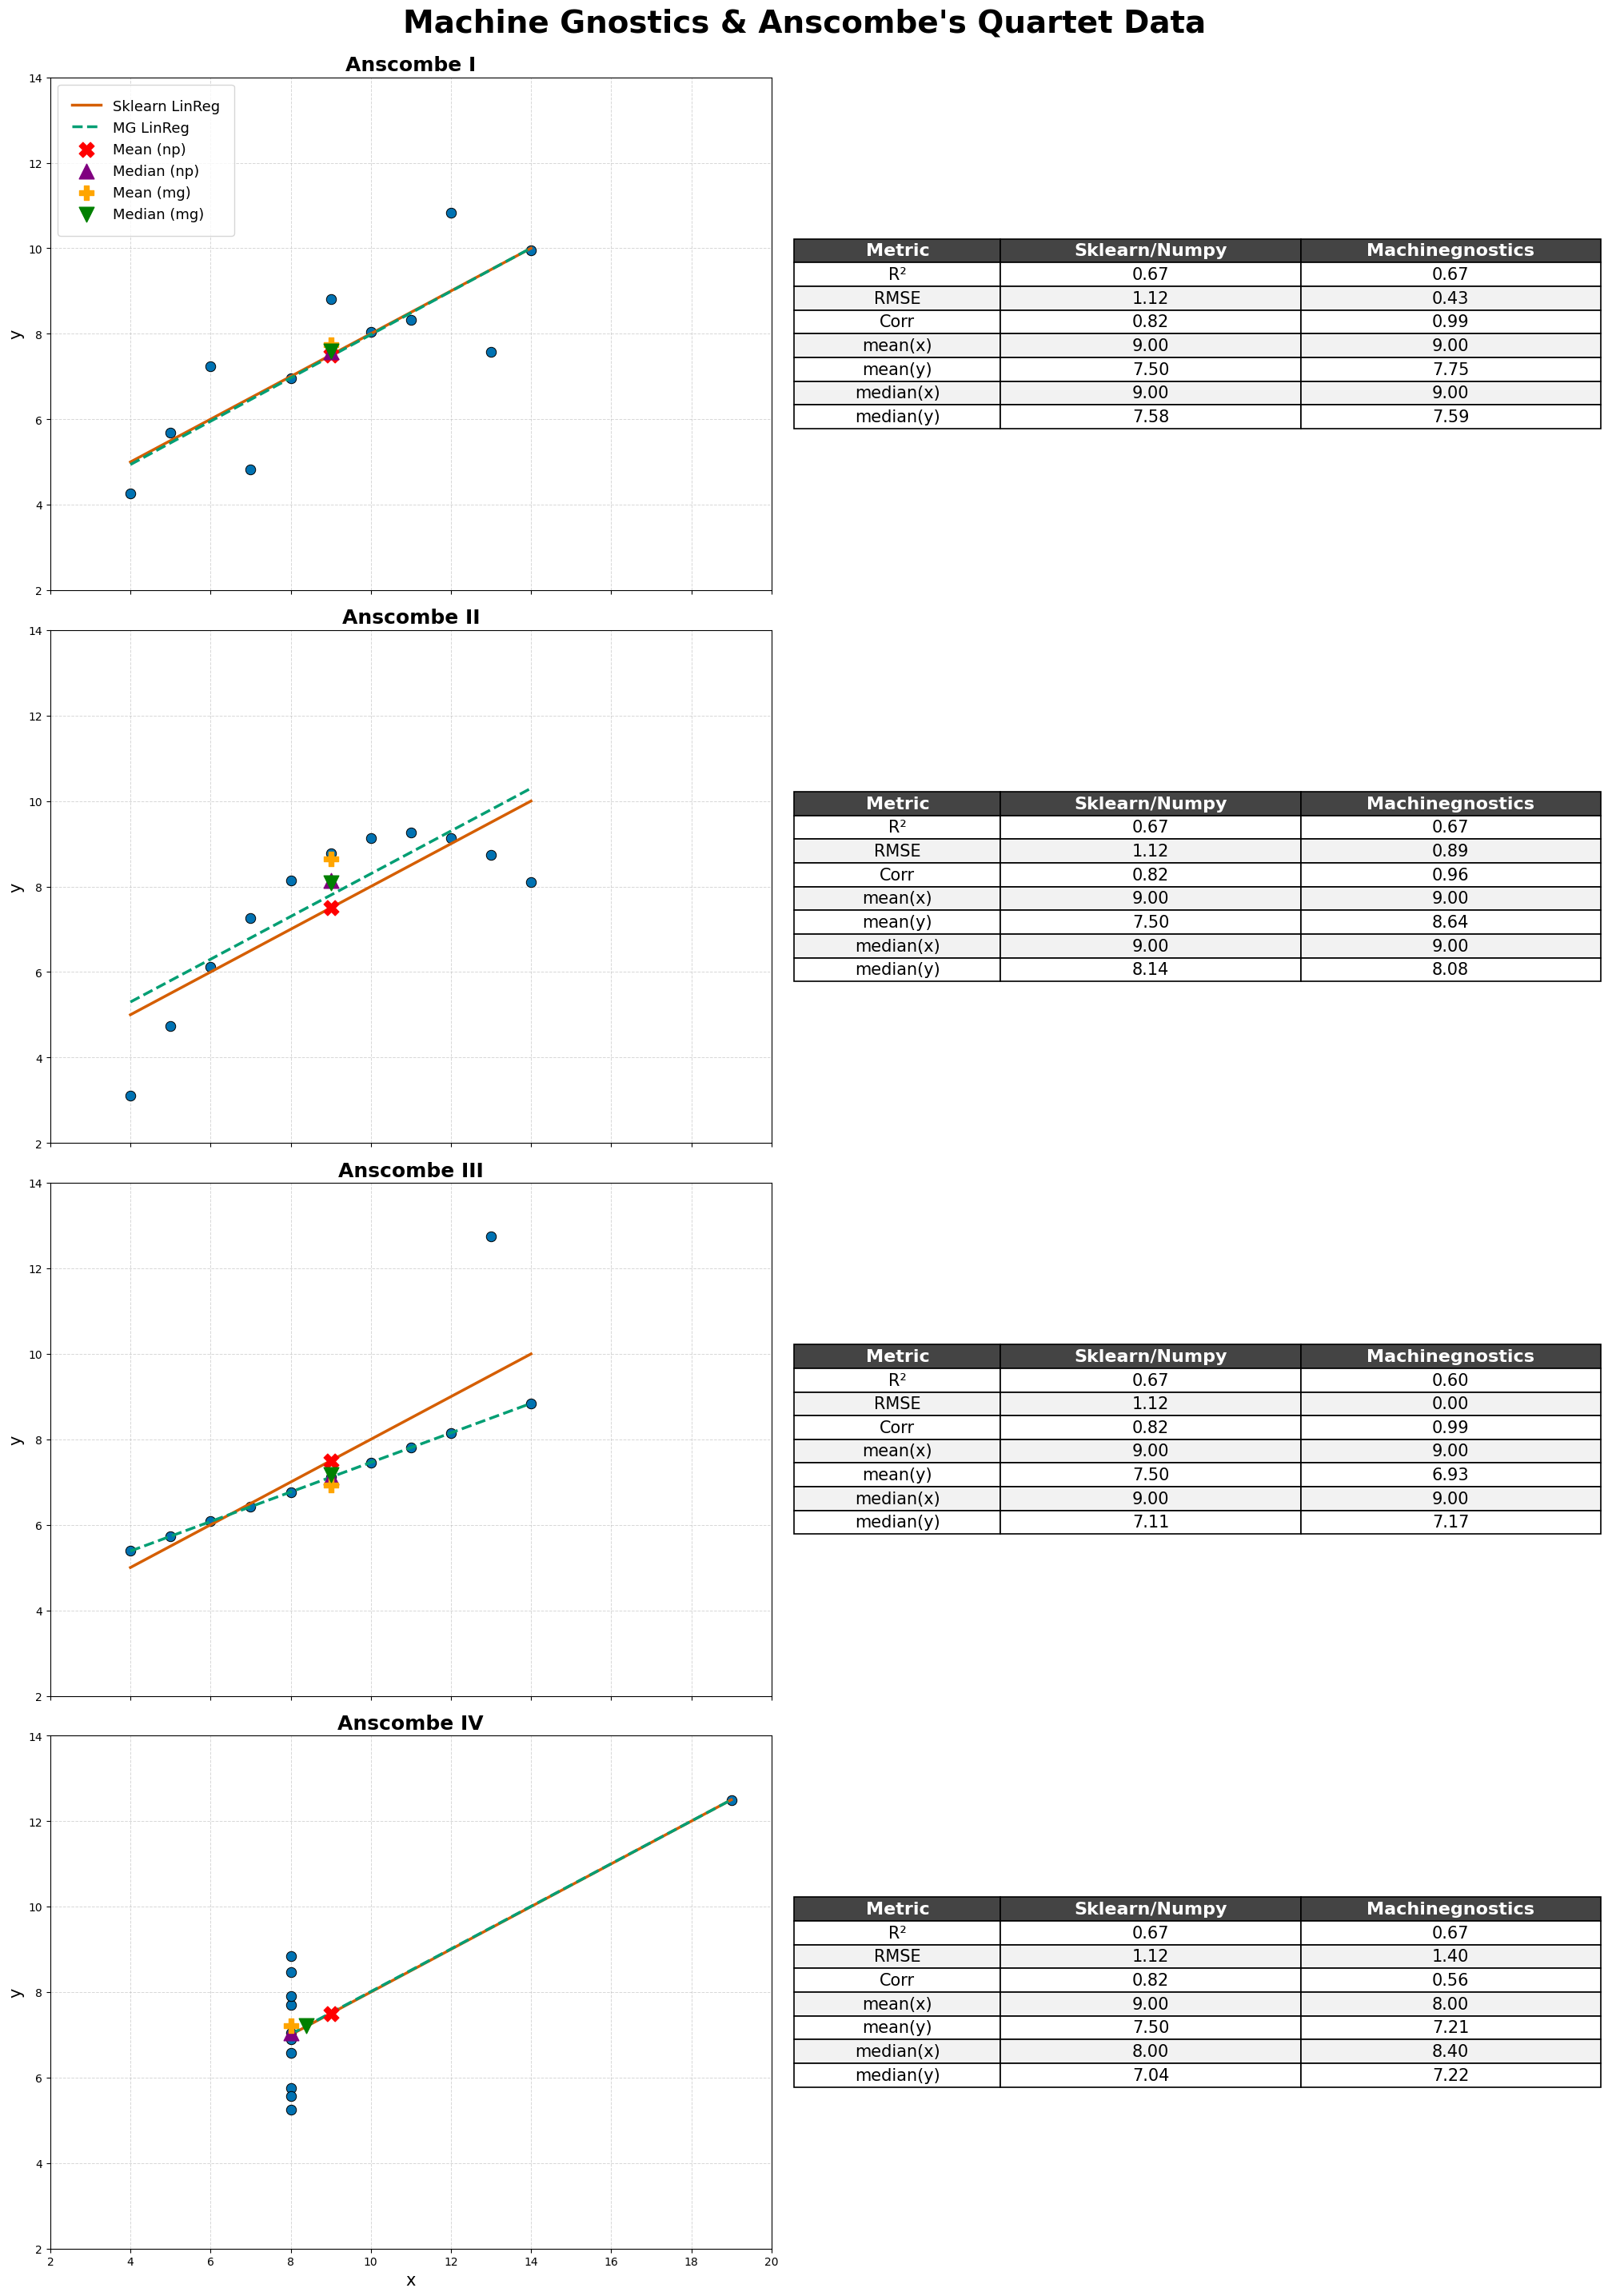

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as sk_r2_score, mean_squared_error as sk_mse

from machinegnostics.models import LinearRegressor
from machinegnostics.metrics import robr2 as mg_r2_score, root_mean_squared_error, correlation, mean, std, median


fig, axes = plt.subplots(4, 2, figsize=(20, 28), sharex=True, sharey=True, constrained_layout=True)
plt.suptitle("Machine Gnostics & Anscombe's Quartet Data", fontsize=28, fontweight='bold', y=1.02)

for row, dataset in enumerate(datasets):
    subset = df[df['dataset'] == dataset]
    X = subset['x'].values.reshape(-1, 1)
    y = subset['y'].values

    # --- Regression lines comparison ---
    ax = axes[row, 0]
    sns.scatterplot(data=subset, x='x', y='y', ax=ax, s=80, color='#0072B2', edgecolor='black', zorder=2)
    ax.set_title(titles[row], fontsize=18, fontweight='bold')
    ax.set_xlim(2, 20)
    ax.set_ylim(2, 14)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.5, zorder=1)

    # Sklearn regression
    sk_model = LinearRegression().fit(X, y)
    sk_y_pred = sk_model.predict(X)
    sk_r2 = sk_r2_score(y, sk_y_pred)
    sk_rmse = sk_mse(y, sk_y_pred, squared=False)
    sk_corr = np.corrcoef(subset['x'], subset['y'])[0, 1]
    x_range = np.linspace(subset['x'].min(), subset['x'].max(), 100).reshape(-1, 1)
    sk_y_range_pred = sk_model.predict(x_range)
    ax.plot(x_range, sk_y_range_pred, color='#D55E00', linestyle='-', linewidth=2.5, label='Sklearn LinReg', zorder=3)

    # Machinegnostics regression
    mg_model = LinearRegressor()
    mg_model.fit(X, y)
    mg_y_pred = mg_model.predict(X)
    mg_r2 = mg_r2_score(y, mg_y_pred)
    mg_rmse = root_mean_squared_error(y, mg_y_pred)
    mg_corr = correlation(X, y)
    mg_y_range_pred = mg_model.predict(x_range)
    ax.plot(x_range, mg_y_range_pred, color='#009E73', linestyle='--', linewidth=2.5, label='MG LinReg', zorder=3)

    # Means, medians (numpy)
    mean_x_np = np.mean(X)
    mean_y_np = np.mean(y)
    median_x_np = np.median(X)
    median_y_np = np.median(y)
    ax.scatter(mean_x_np, mean_y_np, color='red', marker='X', s=180, label='Mean (np)', zorder=4)
    ax.scatter(median_x_np, median_y_np, color='purple', marker='^', s=180, label='Median (np)', zorder=4)

    # Means, medians (machinegnostics)
    mean_x_mg = mean(X.ravel())
    mean_y_mg = mean(y)
    median_x_mg = median(X.ravel())
    median_y_mg = median(y)
    ax.scatter(mean_x_mg, mean_y_mg, color='orange', marker='P', s=180, label='Mean (mg)', zorder=4)
    ax.scatter(median_x_mg, median_y_mg, color='green', marker='v', s=180, label='Median (mg)', zorder=4)

    if row == 0:
        ax.legend(loc='upper left', fontsize=13, frameon=True, fancybox=True, borderpad=1)

    ax.set_xlabel("x", fontsize=15)
    ax.set_ylabel("y", fontsize=15)

    # --- Metrics & Statistics Table ---
    ax = axes[row, 1]
    ax.axis('off')

    std_x_l_mg, std_x_u_mg = std(X.ravel())
    std_y_l_mg, std_y_u_mg = std(y)
    std_x_mg = std_x_u_mg
    std_y_mg = std_y_u_mg

    std_x_np = np.std(X, ddof=1)
    std_y_np = np.std(y, ddof=1)

    table_data = [
        ["Metric", "Sklearn/Numpy", "Machinegnostics"],
        ["R²", f"{sk_r2:.2f}", f"{mg_r2:.2f}"],
        ["RMSE", f"{sk_rmse:.2f}", f"{mg_rmse:.2f}"],
        ["Corr", f"{sk_corr:.2f}", f"{mg_corr:.2f}"],
        ["mean(x)", f"{mean_x_np:.2f}", f"{mean_x_mg:.2f}"],
        ["mean(y)", f"{mean_y_np:.2f}", f"{mean_y_mg:.2f}"],
        ["median(x)", f"{median_x_np:.2f}", f"{median_x_mg:.2f}"],
        ["median(y)", f"{median_y_np:.2f}", f"{median_y_mg:.2f}"],
        # ["std(x)", f"{std_x_np:.2f}", f"{std_x_mg:.2f}"],
        # ["std(y)", f"{std_y_np:.2f}", f"{std_y_mg:.2f}"],
    ]
    table = ax.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.22, 0.32, 0.32])
    table.auto_set_font_size(False)
    table.set_fontsize(15)
    table.scale(1.3, 1.3)
    # Style table header
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_fontsize(16)
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#444444')
        elif key[0] % 2 == 0:
            cell.set_facecolor('#f2f2f2')
        else:
            cell.set_facecolor('white')
        cell.set_linewidth(1.2)

plt.subplots_adjust(top=0.96, wspace=0.15)
plt.savefig("anscombe_quartet_poster.png", dpi=300, bbox_inches='tight')
plt.show()